### Code used for single cell data analysis and generation of anndata object
_Single cell RNA Sequencing Identifies G-protein Coupled Receptor 87 as a Novel Basal Cell Marker of Distal Honeycomb Cysts in IPF_  
Katharina Heinzelmann, Qianjiang Hu, Yan Hu, et al. and Mareike Lehmann, Melanie Königshoff

In [1]:
## Load Libraries 
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb
import bbknn
import warnings
warnings.filterwarnings("ignore")

## Plotting Parameters
sc.set_figure_params(vector_friendly = True)
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
sb.set_style("ticks")

from matplotlib import colors
col = ["lightgray", "red", "darkred"] 
gray_red = colors.LinearSegmentedColormap.from_list("grouping", col, N = 128)
col = ["lightgray", "cornflowerblue", "darkblue"]
gray_blue = colors.LinearSegmentedColormap.from_list("grouping", col, N = 128)

## Set Filepaths 

dge_path = "./ipf/data/"
out_folder = "./ipf/output/"
object_folder = "./ipf/object/"

sc.logging.print_version_and_date()

Running Scanpy 1.8.0, on 2021-10-20 15:50.


### Read in data set
QC and pre-processing starting from raw counts has been performed in pre-process_generate_object.ipynb

In [2]:
adata = sc.read(object_folder + "GPR87IPF_preprocessed.h5ad")

### Calculate Principal Components, batch-balanced knn Graph and UMAP

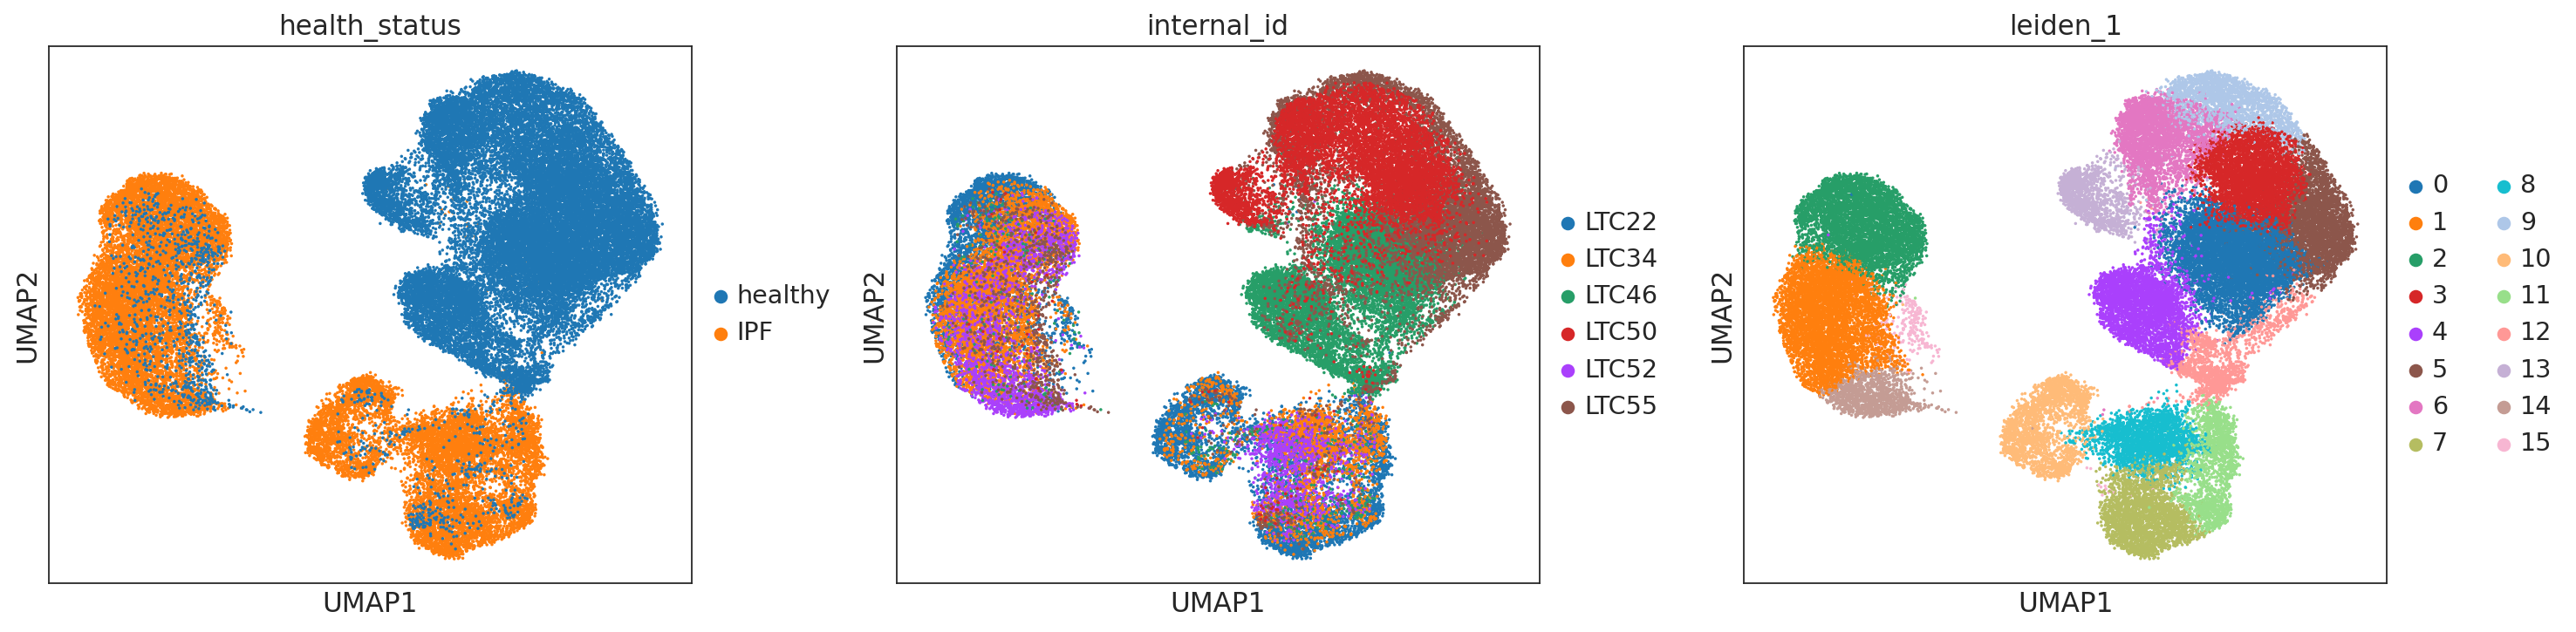

In [3]:
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True)
bbknn.bbknn(adata, batch_key = "internal_id", neighbors_within_batch = 4, n_pcs = 30)
sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 1, key_added = "leiden_1")
adata.obs.health_status.cat.reorder_categories(["healthy", "IPF"], inplace = True)

sc.pl.umap(adata, color = ["health_status", "internal_id", "leiden_1"], wspace = 0.2, size = 10)

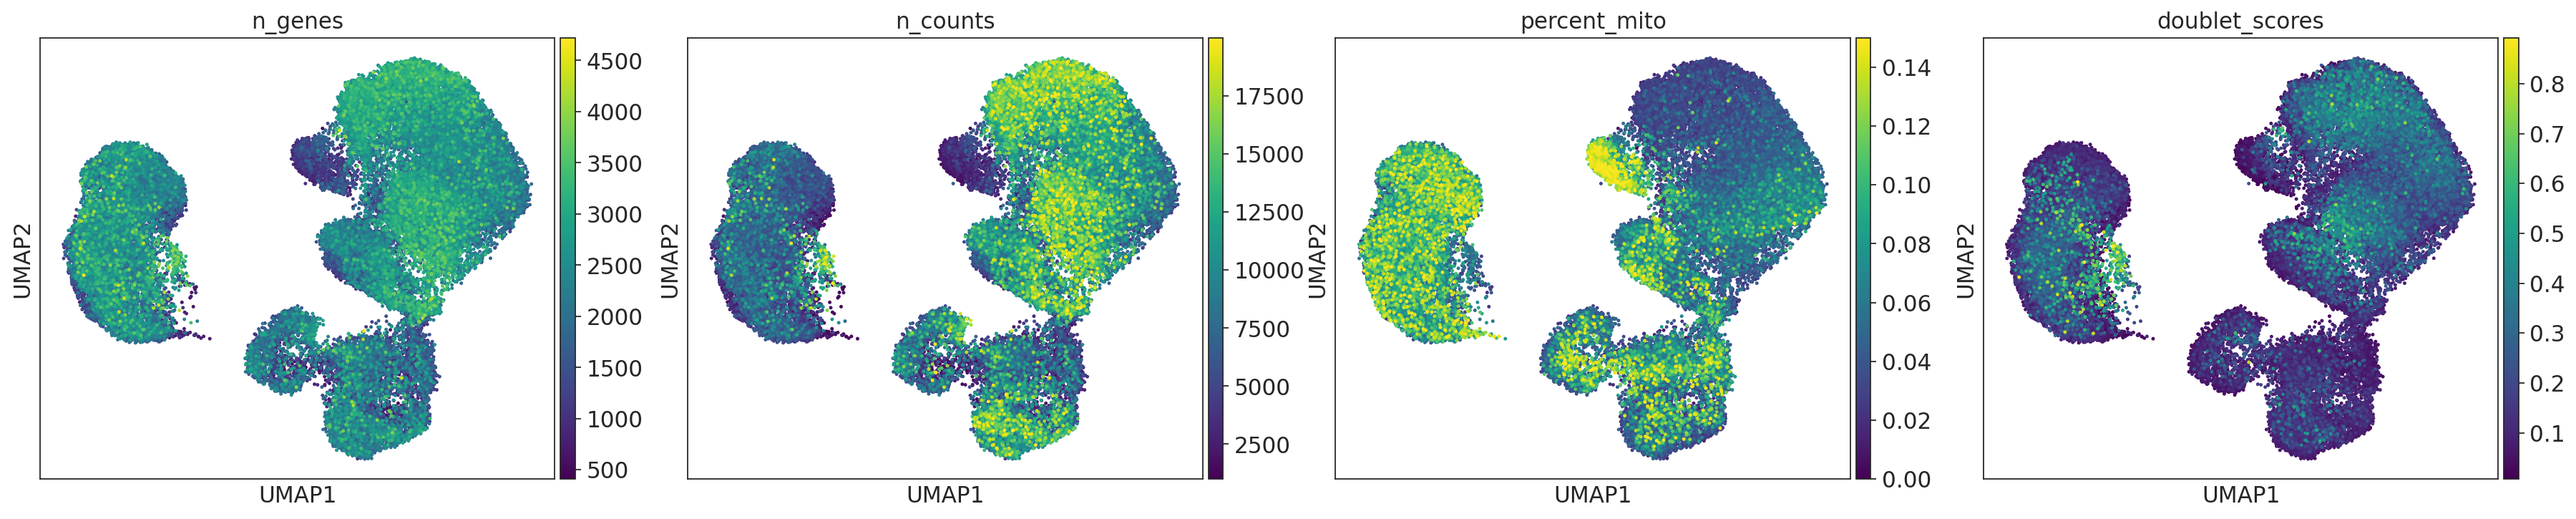

In [4]:
sc.pl.umap(adata, color = ["n_genes", "n_counts", "percent_mito", "doublet_scores"], cmap = "viridis", size = 20)

### Add cell type annotation

In [5]:
meta = pd.read_csv(folder + "GPR87IPF_cells_metadata.txt", sep = "\t", index_col = 0)

## Filter away the two seemingly low quality cluster (high doublet_scores, high pct of mitochondrial transcripts)
adata = adata[-adata.obs.leiden_1.isin(["13", "15"])].copy()

## Add final annotation as in meta file
adata = adata[meta.index].copy()
adata.obs = meta.iloc[:, 0:10]
sc._utils.sanitize_anndata(adata)

... storing 'patient_ID' as categorical
... storing 'smoke_status' as categorical
... storing 'health_state' as categorical
... storing 'cell_type' as categorical


### Dimensionality Reduction and Visualization

In [6]:
sc.pp.pca(adata, n_comps = 50, use_highly_variable = True)
bbknn.bbknn(adata, batch_key = "patient_ID", neighbors_within_batch = 4, n_pcs = 20)
sc.tl.umap(adata)

## Set colours
adata.obs.health_state.cat.reorder_categories(["healthy", "IPF"], inplace = True)
adata.obs.cell_type.cat.reorder_categories(['AT1', 'AT2', 'Ciliated', 'Deuterosomal', 'Basal', 'Suprabasal',
                                            'Cycling', 'Club', 'Goblet'], inplace = True)
adata.uns["cell_type_colors"] = ['tab:blue', 'rebeccapurple', 'tab:red', 'sienna', 'tab:green',
                                 'violet', 'gold', 'lightsteelblue', 'rosybrown']

sc.pl.umap(adata, color = ["health_state", "patient_ID", "cell_type"], wspace = 0.3, size = 8)

In [7]:
sc.pl.umap(adata, color = ["n_counts", "n_genes", "percent_mito", "doublet_scores"], size = 10, cmap = "viridis")

### Cell type marker visualizations

In [8]:
marker = ["AGER",  "SFTPB",  "FOXJ1", "TP63", "SCGB3A2", "MUC5AC",
          "RTKN2", "SFTPC", "TMEM190", "KRT5", "MGP", "MUC5B"]

sc.pl.umap(adata, color = marker, size = 20, ncols = 6, cmap = gray_red)

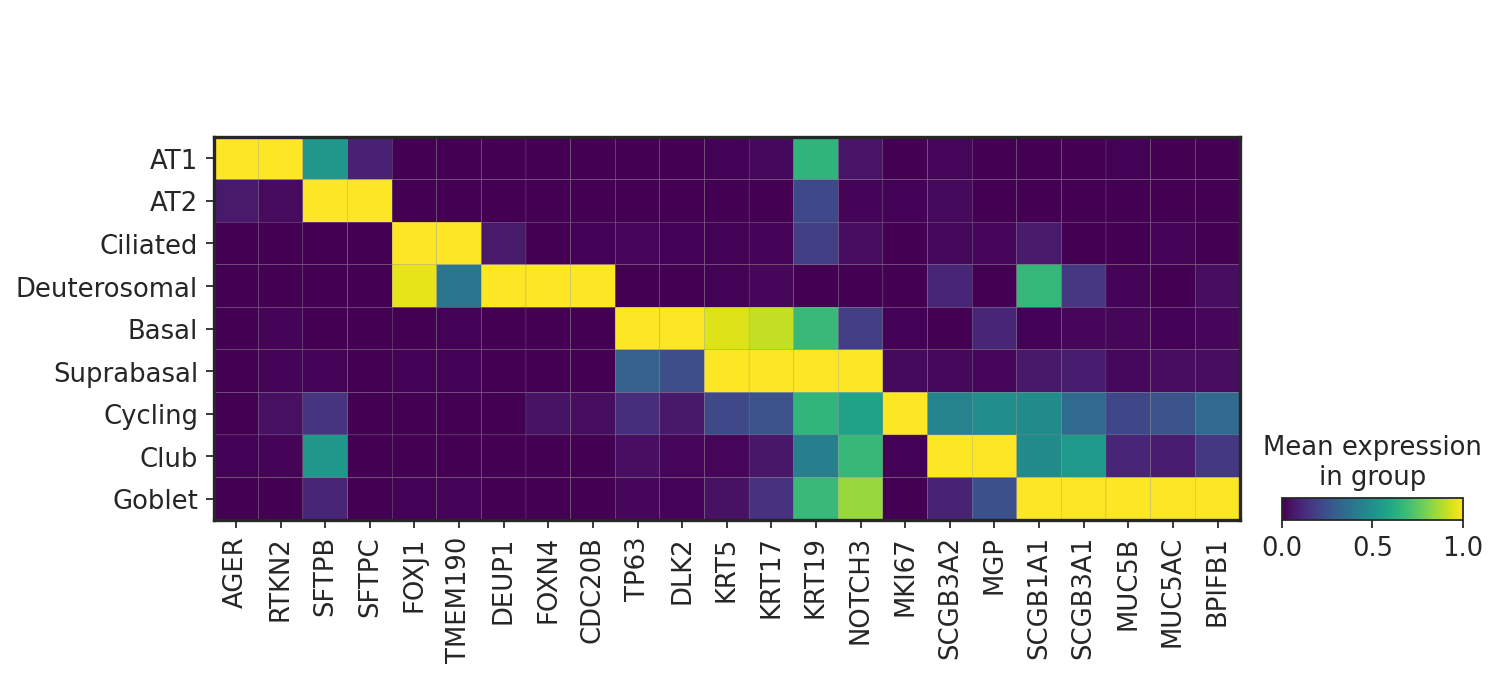

In [9]:
marker = ["AGER", "RTKN2", "SFTPB", "SFTPC", "FOXJ1", "TMEM190", "DEUP1", "FOXN4", "CDC20B",
          "TP63", "DLK2", "KRT5", "KRT17", "KRT19", "NOTCH3", "MKI67", "SCGB3A2", "MGP", "SCGB1A1", 
          "SCGB3A1", "MUC5B", "MUC5AC", "BPIFB1"]
sc.pl.matrixplot(adata, var_names = marker, groupby = "cell_type", standard_scale = "var")

... storing 'cell_type_condition' as categorical


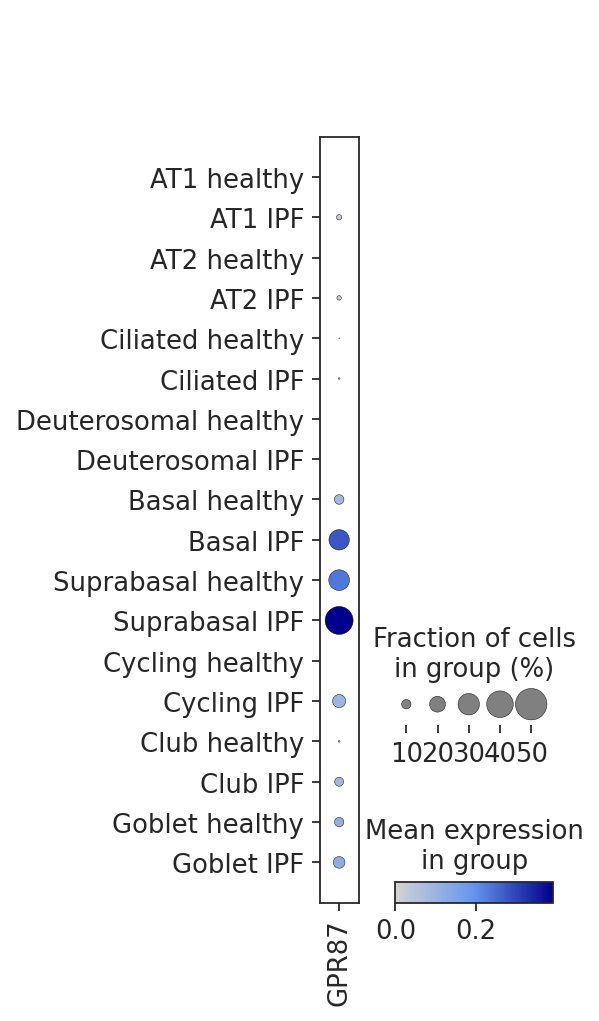

In [10]:
adata.obs["cell_type_condition"] = ["%s %s" %(ct, d) for ct, d in zip(adata.obs.cell_type, adata.obs.health_state)]
sc._utils.sanitize_anndata(adata)

## Set order the celltype condition column
order = []
for ct in adata.obs["cell_type"].cat.categories:
    for d in ["healthy", "IPF"]:
        order.append("%s %s" %(ct, d))
adata.obs.cell_type_condition.cat.reorder_categories(order, inplace = True)

from ma_codes import gray_blue
sc.pl.dotplot(adata, var_names = ["GPR87"], groupby = "cell_type_condition", cmap = gray_blue)

### Save final annotated object

In [11]:
adata.write(out_folder + "GPR87IPF_annotated.h5ad")